http://blog.ezyang.com/2019/05/pytorch-internals/

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Read dataset
path_in = "../data/names.txt"
with open(path_in, 'r') as fh:
    words = fh.read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(chars) + 1

In [4]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # rolling window
    return torch.tensor(X), torch.tensor(Y)

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr,  Ytr  = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])
Xtr.shape, Ytr.shape, Xval.shape, Yval.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [50]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(123)
C = torch.randn((vocab_size, n_embed), generator=g) # 
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) 
b2 = torch.randn(vocab_size, generator=g) 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
lossi = []
sum(p.nelement() for p in parameters)

11897

In [49]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train'), split_loss('val')

train 2.0390868186950684
val 2.10430908203125


(None, None)

In [51]:
max_steps = 200_000
batch_size = 32

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(i, loss.item())
    lossi.append(loss.log10().item())
    # break
    

0 22.660118103027344
10000 2.0721559524536133
20000 2.3520164489746094
30000 2.1965737342834473
40000 2.592329502105713
50000 2.2140629291534424
60000 2.7797722816467285
70000 2.32149338722229
80000 2.70660138130188
90000 2.2991273403167725
100000 2.4198198318481445
110000 1.9405189752578735
120000 2.121194839477539
130000 2.211531639099121
140000 1.532693862915039
150000 2.091735363006592
160000 2.230393886566162
170000 1.970759391784668
180000 2.1723475456237793
190000 2.7138073444366455


(array([258., 185., 181., 151., 155., 141., 147., 130., 146., 119., 123.,
        114., 120., 130.,  99., 115., 103., 130., 110.,  96., 123., 101.,
        113., 122.,  92., 111., 117.,  97., 106., 106., 115.,  91., 121.,
        111.,  93.,  97., 111., 128., 117., 107., 132., 125., 131., 106.,
        122., 152., 142., 172., 193., 193.]),
 array([-9.99716520e-01, -9.59723521e-01, -9.19730523e-01, -8.79737524e-01,
        -8.39744525e-01, -7.99751526e-01, -7.59758527e-01, -7.19765528e-01,
        -6.79772530e-01, -6.39779531e-01, -5.99786532e-01, -5.59793533e-01,
        -5.19800534e-01, -4.79807535e-01, -4.39814537e-01, -3.99821538e-01,
        -3.59828539e-01, -3.19835540e-01, -2.79842541e-01, -2.39849542e-01,
        -1.99856544e-01, -1.59863545e-01, -1.19870546e-01, -7.98775470e-02,
        -3.98845482e-02,  1.08450651e-04,  4.01014495e-02,  8.00944483e-02,
         1.20087447e-01,  1.60080446e-01,  2.00073445e-01,  2.40066444e-01,
         2.80059443e-01,  3.20052441e-01,  3.60045

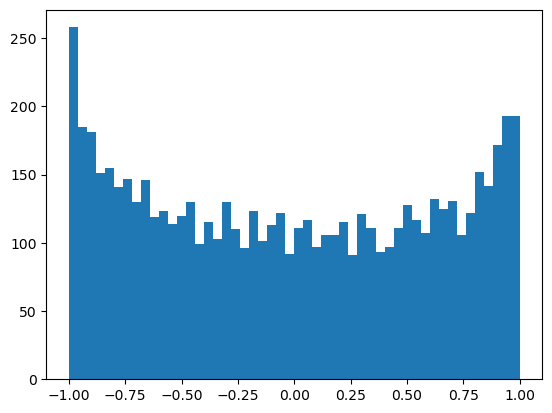

In [47]:
# distribution of h = post-activation
plt.hist(h.view(-1).tolist(), bins=50)

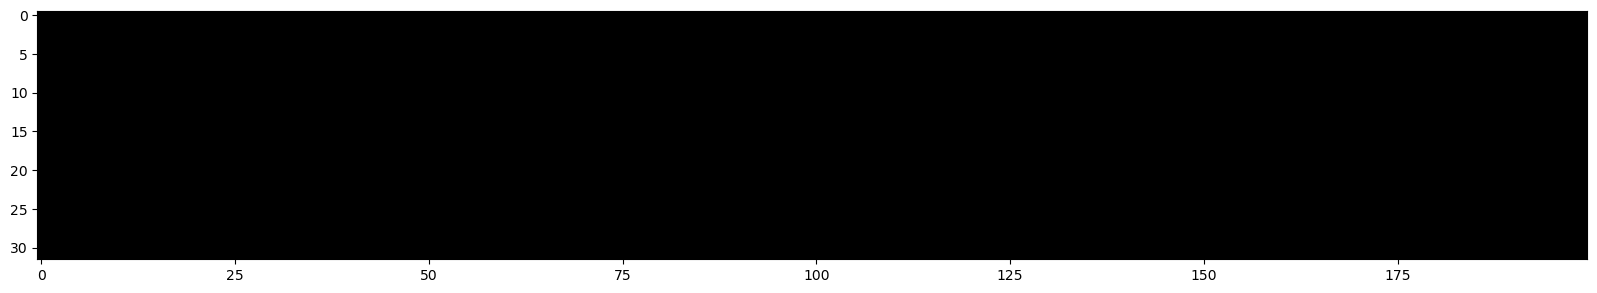

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Vanishing gradient
Since the gradients have values close to 1/-1 in most cases, they are going to zero out the gradient in the derivative of tanh. So **the neuron will not learn**. Distribution of h = post-activation:

<img src="imgs/h_plot.png" width=300>

<img src="imgs/tanh.png">

The white gradients will be zero:

<img src="imgs/zero_grad.png">

If an entire column is white, that's a dead neuron = initial values of W are such that all of the learning examples landed in the tail of the activation function, none in the active part

Dead neuron
- always activates by 1/-1 and never learns because the gradient gets zeroed out
- neuron's weights and biases are such that it always outputs values close to zero, regardless of the input
- takes no role in discriminating between inputs


"active part of the tanh"

### Other activation functions and vanishing gradient
- tanh 
- sigmoid <br><img src="imgs/sigmoid_derivative.png" width=150>
- ReLU - d'(x) = 0 if x < 0 else 1 <br>
If at least one input 𝑥∗ has our ReLU on the steep side, then the ReLU is still alive. Otherwise an unfortunate set of inputs can kill the neuron<br>
Dead neurons can appear in the initialization or in the optimization with too large lr<br>
<img src="imgs/relu_derivative.png" width=150>
- leaky ReLU - provides some learning even for negative examples, so the neuron can recover, no dead neurons
- ELU has flat parts so the gradient may vanish

<img src="imgs/act_functions.png">


No/Preactivation
```
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
```

<img src="imgs/h_plot.png" width=300>
<img src="imgs/h_preact_plot.png" width=300>
<br>
<img src="imgs/zero_grad.png" width=300>
<img src="imgs/tanh_preact.png" width=300>

```


train 2.0390868186950684
val 2.10430908203125
```

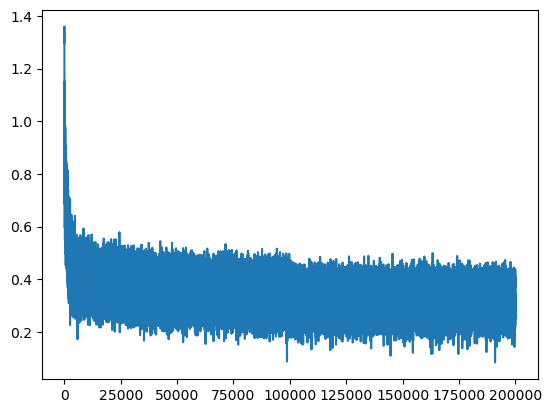

In [7]:
plt.plot(lossi)

In [10]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

xivi.
aya.
teem.
brigansh.
abel.
deme.
myrriganni.
maxxancone.
tahaia.
tubdiry.
cauzuelen.
azerick.
ever.
grann.
atvi.
julie.
kari.
aubrins.
colaylona.
jaydtoder.
